In [1]:
from tensorflow.keras.models import load_model

import numpy as np
from tensorflow.image import extract_patches
import rasterio
import tensorflow as tf

In [2]:
# List available physical devices and check for GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

if physical_devices:
    # Set memory growth to prevent memory allocation issues
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected. Using CPU.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
patch_size=5
model_path="output/model/palisades_lstm.h5"
model = load_model(model_path)


sar_image_path="output/sar/eaton_sar_ready.tif"
output_prediction_path="output/prediction/palisadeslstm_eaton_pred.tif"
output_image_path="output/prediction_img/palisadeslstm_eaton_pred.png"




# sar_image_path="output/sar/paliades_sar_ready.tif"
# output_prediction_path="output/prediction/palisadeslstm_pred.tif"
# output_image_path="output/prediction_img/palisadeslstm_pred.png"


2025-04-11 11:18:22.457063: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-11 11:18:22.457080: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-11 11:18:22.457084: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-11 11:18:22.457106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-11 11:18:22.457117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import numpy as np

def create_patch(data_set, patch_size=5):
    """
    Creates a patch for every pixel in the dataset.
    
    Parameters:
    data_set (numpy array): 3D NumPy array representing the dataset (rows, cols, bands).
    patch_size (int): Size of the square patch (default: 5).
    
    Returns:
    numpy array: 4D array of shape (rows * cols, patch_size, patch_size, bands).
    """
    rows, cols, bands = data_set.shape
    max_row, max_col = rows - 1, cols - 1
    
    # Initialize the output tensor
    input_tensor = np.zeros((rows * cols, patch_size, patch_size, bands))
    
    # Iterate over each pixel to create patches
    index = 0
    for row in range(rows):
        for col in range(cols):
            patch = np.zeros((patch_size, patch_size, bands))
            patch_top_row = row - patch_size // 2
            patch_left_col = col - patch_size // 2
            
            for i in range(patch_size):
                for j in range(patch_size):
                    patch_row = patch_top_row + i
                    patch_col = patch_left_col + j
                    
                    # Ensure the indices are within the valid range
                    if 0 <= patch_row <= max_row and 0 <= patch_col <= max_col:
                        patch[i, j, :] = data_set[patch_row, patch_col, :]
            
            input_tensor[index] = patch
            index += 1
    
    return input_tensor

In [5]:
with rasterio.open(sar_image_path) as dataset:
    data_set = dataset.read([1,2,3,4,5,6,7,8]) 
    data_set = np.transpose(data_set, (1, 2, 0))
    metadata=dataset.meta.copy()

In [6]:
width,height,_=data_set.shape

In [7]:

input_tensor=create_patch(data_set, patch_size=patch_size)

In [8]:
input_tensor.shape

(2186883, 5, 5, 8)

In [9]:
predictions = model.predict(input_tensor)

2025-04-11 11:18:49.844543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-11 11:18:49.955107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-11 11:18:50.005448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-11 11:18:50.042610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


68341/68341 [==============================] - 215s 3ms/step


In [10]:
# predictions
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
predicted_map = predicted_labels.reshape(width, height)

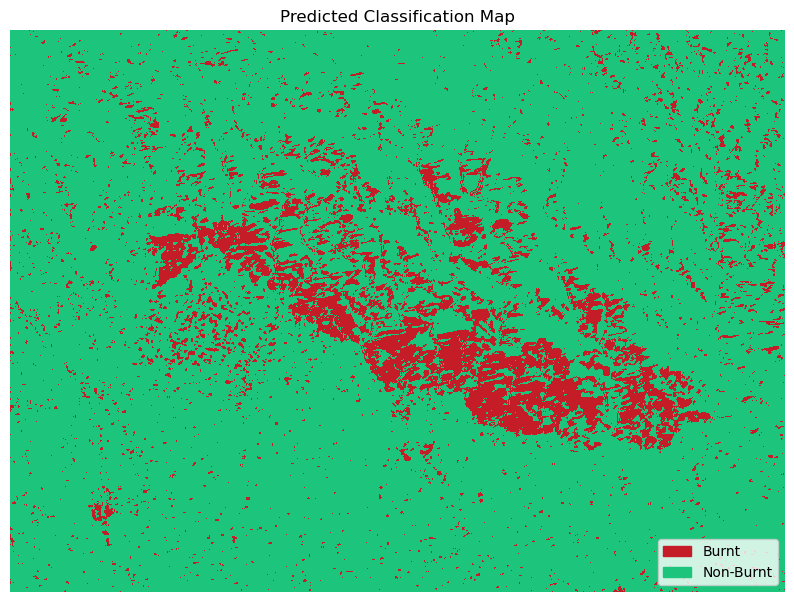

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

plt.figure(figsize=(10, 10))
cmap = mcolors.ListedColormap(['#1dc47c', '#c41d28'])

plt.imshow(predicted_map, cmap=cmap,interpolation='nearest')  # Use a colormap that highlights classes
# plt.colorbar(label="Predicted Classes")
plt.title("Predicted Classification Map")
plt.axis("off")
legend_patches = [
        mpatches.Patch(color='#c41d28', label='Burnt'),
        mpatches.Patch(color='#1dc47c', label='Non-Burnt')
    ]

plt.legend(handles=legend_patches, loc='lower right', frameon=True)
plt.savefig(output_image_path,bbox_inches='tight', dpi=300)

plt.show()


In [14]:
# import tifffile as tiff
# # Save as TIFF
# tiff.imwrite(output_prediction_path, predicted_map.astype(np.float32))

with rasterio.open(output_prediction_path, 'w', **metadata) as dst:
    dst.write(predicted_map.astype(np.float32), 1) 

In [13]:
# with rasterio.open("output/prediction/palisades.tif") as src:
#     image = src.read(1)  # Read the first band
#     profile = src.profile  # Get metadata

#     # Display image properties
#     # print(f"TIFF Metadata for {os.path.basename(tiff_path)}:", profile)

#     # Plot the first band
#     plt.figure(figsize=(10, 6))
#     plt.imshow(image, cmap="gray")  # Change cmap as needed
#     plt.colorbar(label="Pixel Values")
#     # plt.title(f"TIFF Image - {os.path.basename(tiff_path)}")
#     plt.axis("off")
#     plt.show()